In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.multiprocessing as mp
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import numpy
import utils

In [1]:
%load_ext autoreload
%autoreload 3

In [4]:
logdir = 'runs/MLP'
# track runing logs
writer = SummaryWriter(logdir)

In [2]:
root = '../data'
# Download training data from open datasets.
training_data = datasets.EMNIST(
    root=root,
    split="byclass",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.EMNIST(
    root=root,
    split="byclass",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [3]:
# all classes in order
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
           'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
           'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 
           'U', 'V', 'W', 'X', 'Y', 'Z','a', 'b', 'c', 'd', 
           'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 
           'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z')

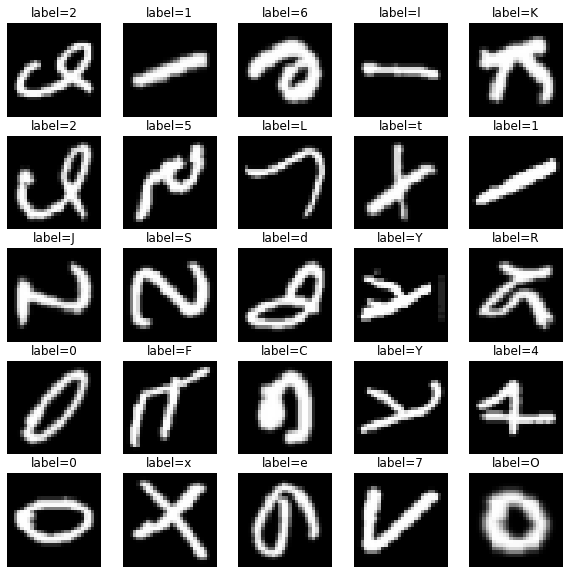

In [5]:
# 随机展示 5*8 个图片

figure = plt.figure(figsize=(10, 10)) # 制作一个画板
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    # 随机取一个training data的索引值
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    # 获取对应的training data
    # img为norm后的像素矩阵 label为该图像的label
    img, label = training_data[sample_idx]
    # 在一个画板中加多个子画板
    figure.add_subplot(rows, cols, i)
    # 加每个画板的标签
    plt.title(f"label={classes[label]}")
    # 不显示坐标轴
    plt.axis(False)
    # img.squeeze()是去掉img这个tensor中维度为1的维
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [6]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size,shuffle=True,num_workers=0)
test_dataloader = DataLoader(test_data, batch_size=batch_size,num_workers=0)

In [7]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
devcie = torch.device(device)
print(f"Using {device} device")

Using cpu device


In [8]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,62)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [9]:
model = NeuralNetwork().to(device)
# print(model)

In [10]:
lr = 1e-4
# 损失函数
loss_fn = nn.CrossEntropyLoss()
# 梯度下降算法 优化器
# optimizer = torch.optim.SGD(model.parameters(), lr=lr,momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

In [11]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    utils.train(train_dataloader,device,model, loss_fn, optimizer)
    utils.test(test_dataloader, device, model, loss_fn)
    utils.write_loss_acc(writer,device,t,model,loss_fn,train = train_dataloader,test = test_dataloader)
print("Done!")

Epoch 1
-------------------------------
loss: 4.140440  [    0/697932]
loss: 1.624385  [64000/697932]
loss: 1.182106  [128000/697932]
loss: 1.312081  [192000/697932]
loss: 1.318281  [256000/697932]
loss: 1.208790  [320000/697932]
loss: 0.921342  [384000/697932]
loss: 1.273164  [448000/697932]
loss: 1.242350  [512000/697932]
loss: 0.841891  [576000/697932]
loss: 0.844109  [640000/697932]
Test Error: 
 Accuracy: 77.6%, Avg loss: 0.711774 

Epoch 2
-------------------------------
loss: 0.851021  [    0/697932]
loss: 1.109553  [64000/697932]
loss: 0.863966  [128000/697932]
loss: 0.782243  [192000/697932]
loss: 0.873653  [256000/697932]
loss: 0.722151  [320000/697932]
loss: 0.708046  [384000/697932]
loss: 0.747251  [448000/697932]
loss: 0.870628  [512000/697932]
loss: 0.970045  [576000/697932]
loss: 0.965323  [640000/697932]
Test Error: 
 Accuracy: 80.7%, Avg loss: 0.585441 

Epoch 3
-------------------------------
loss: 0.744705  [    0/697932]
loss: 0.475857  [64000/697932]
loss: 0.595678

In [13]:
# check f1 score 
y_pred,y_true = utils.compute_f1(test_dataloader,device,model)

f1 score in micro : 0.842679435709189
f1 score in weighted : 0.8217584495697862


f1 score in micro : 0.842679435709189
f1 score in weighted : 0.8217584495697862


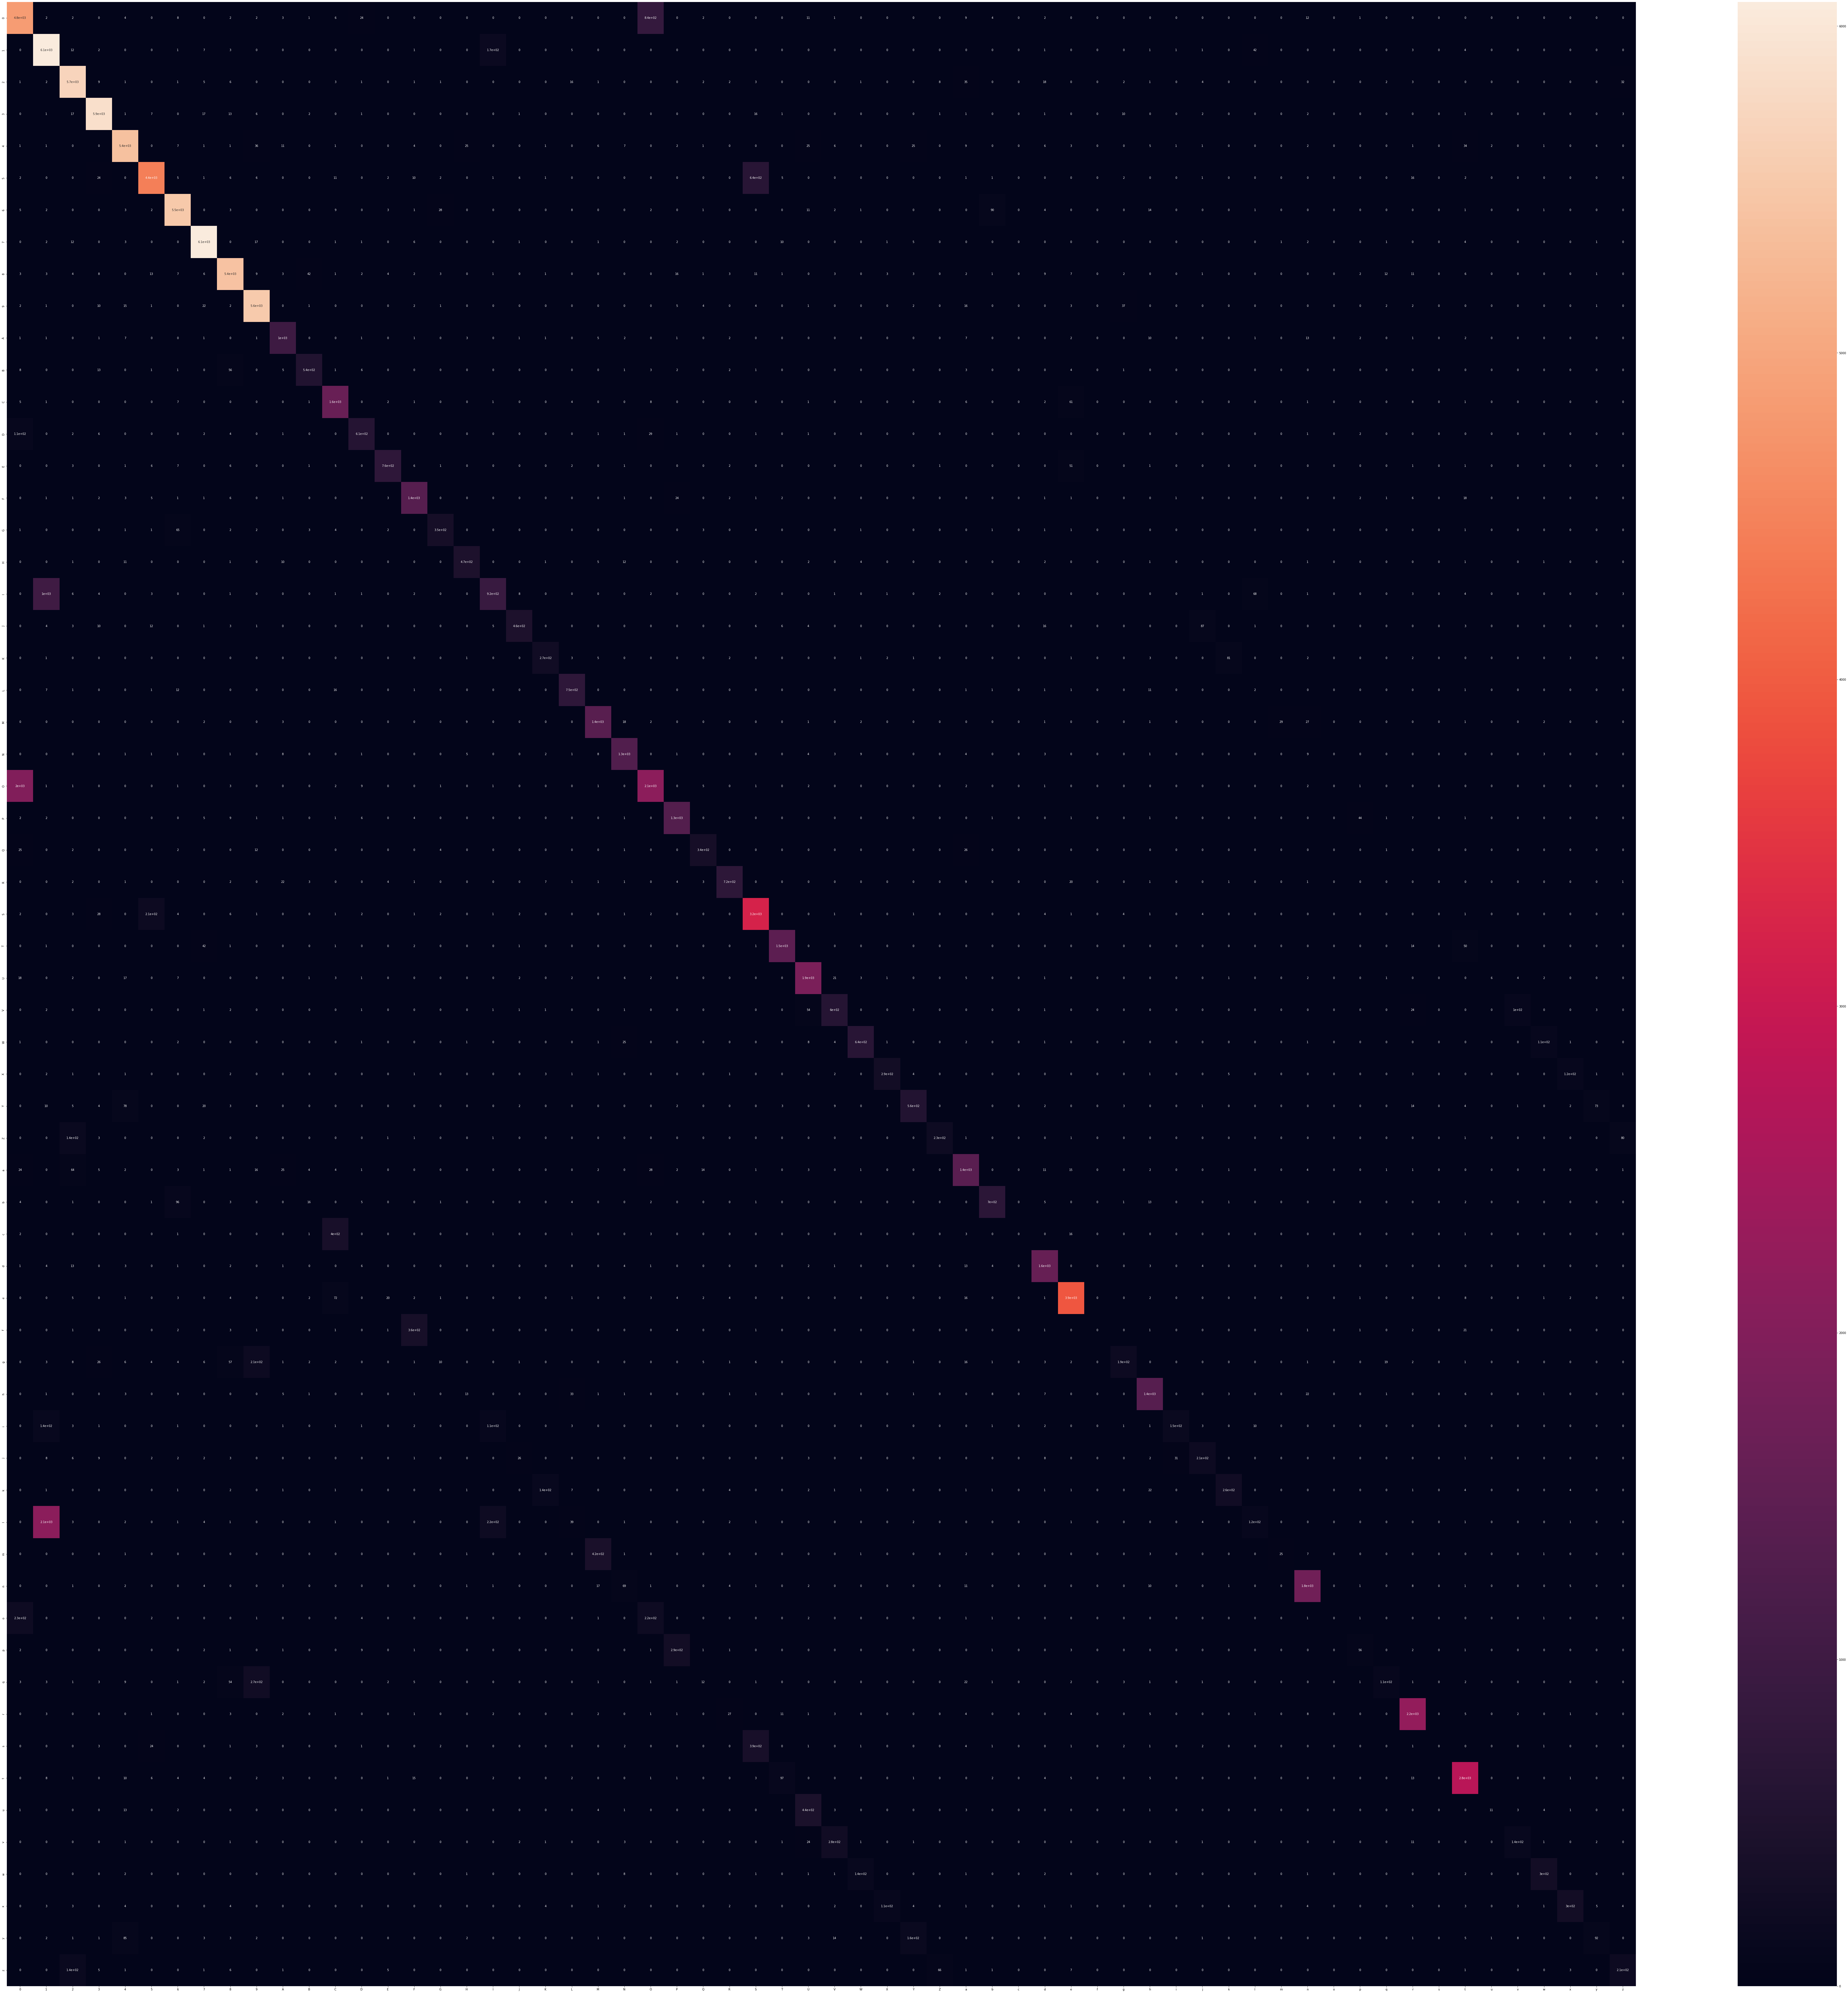

In [16]:
# check confusion matrix
utils.get_CM(test_dataloader,device,model,classes,savefile='MLP_CM.png')

In [17]:
torch.save(model,'MLP_model')